**INTRODUCTION**
**Context:**
Since my childhood I'm a fan of the Simpsons serie. I watched The Simpson episodes -multiple times each- over the years. I wanted to build a CNN model which can recognize the differents caracters of the serie.

The model was a Convolutional Neural Network trained on a dataset of 20.000 images and he learned each caracters. The most populars caracters were learned with more than 1k images when the less popular's one were learned with only 400 images. 

I choosed to build the model using the Pytorch librairie and the langage Python. 

On the first step, we will prepare the data and then, we will work on the CNN modeling and evaluation.


1. Introduction
2. Data preparation
2.1 Load and prepare the data
2.2 Normalization
2.3 Label encoding
3. Convolutional Neural Network
3.1 Define the model
3.2 Set the optimizer and annealer
3.3 Data augmentation and fitting
4. Evaluate the model
4.1 Confusion matrix
4.2 Some examples
5. Using CNN dynamically
5.1 Video demo

**Dataset:**
url: https://www.kaggle.com/alexattia/the-simpsons-characters-dataset


The dataset is composed by:

**Dataset metadata:**
Train: 20 folders (one for each character) with 400-2000 pictures in each folder.
Test: 990 pictures



In [164]:
# Import librairies
import torch
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils import data as D
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.metrics import confusion_matrix, accuracy_score
import pdb
torch.set_printoptions(linewidth=120)

**DATA PREPARATION**
<br>
On the first step we make some commons images transformations. [As we can see on the documentation](https://pytorch.org/docs/stable/torchvision/transforms.html), they can be chained together using Compose. 
 - We apply a resize rule to normalize the images width and height.
 - Images are converted into tensor.
 - Normalize a tensor image with mean and standard deviation
We fetch the differents pictures with the [ImageFolder](https://pytorch.org/docs/stable/data.html) function provided on the Pytorch librairy. PyTorch ImageFolder assumes that images are organized in the following way:

*/data/train/abraham_grampa_simpson/pic_001.jpg* <br>
*/data/train/lisa_simpson/pic_007.jpg*

where **abraham_grampa_simpson** and **lisa_simpson** are class labels. 

Then, we will use the data loading utility function [DataLoader](https://pytorch.org/docs/stable/data.html) to loads the data.


In [188]:

transform = transforms.Compose(
    [transforms.Resize((60,60)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data = ImageFolder(root="data/train/",transform=transform)
dataloader = DataLoader(data, batch_size=16,shuffle=True,num_workers=2)

dataiter = iter(dataloader)
images, labels = dataiter.next()

##  Training & validation steps
When we build machine learning models, it's quite common to split the dataset into 3 parts: 
1. Training is the step to train the model, compute the loss and adjust the weight using the gradient descent
2. Validation is the step to evalute the model during the training. Usually, we adjust the hyperparameters (learning rate, etc) to pick the best model. 
3. Test is the step to compare different models, or different types of modeling approaches, and to report the final accuracy of the model.


In [171]:
data.len = len(data)
train_size = int(0.7 * data.len)
test_size = data.len - train_size
trainset, random_set = D.random_split(data, lengths=[train_size, test_size])

**Let's verify the sizes of the datasets.**

In [173]:
# Dataset length
print('Dataset length:', data)

# Train size
print('Train size:', train_size)

# Test size
print('Test size', test_size)


Dataset length: Dataset ImageFolder
    Number of datapoints: 20933
    Root location: data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(60, 60), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Train size: 14653
Test size 6280


Now, we use an utility function to print a samples images from the training dataloader.

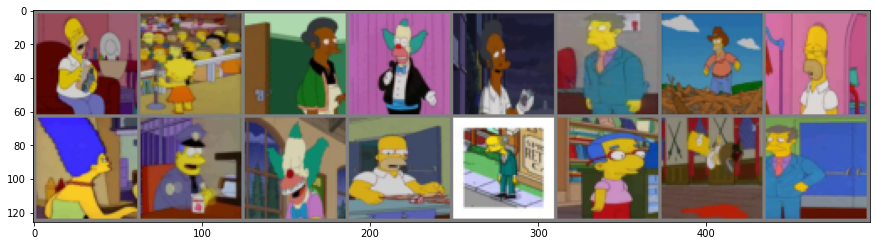

In [183]:
def sample_images(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

sample_images(torchvision.utils.make_grid(images))


## **Define the model**

In this part, we will work on the Network.

The first important things to understand is the convolutional layer (Conv2D).
*[The CNN gets its name from the process of Convolution, which is the first filter applied as part of the feature-engineering step. Think of convolution as applying a filter to our image. We pass over a mini image, usually called a kernel, and output the resulting, filtered subset of our image.*](https://algorithmia.com/blog/convolutional-neural-nets-in-pytorch)

![image info](./img/convolutional.png)
***Source: Tess Ferrandez, Inspiration Ninja at Microsoft https://fr.slideshare.net/TessFerrandez/notes-from-coursera-deep-learning-courses-by-andrew-ng***

In practice, we need to multiply small parts of our input images by a filter. 

We can adjust few parameters:

**Kernel Size** – the size of the filter.<br>
**Kernel Type** – the values of the actual filter. Some examples include identity, edge detection, and sharpen.<br>
**Stride** – the rate at which the kernel passes over the input image. A stride of 2 moves the kernel in 2-pixel increments.<br>
**Padding** – we can add layers of 0s to the outside of the image in order to make sure that the kernel properly passes over the edges of the image.<br>
**Output Layers** – how many different kernels are applied to the image.<br>

![image info](./img/parameters.png)

***Source: Tess Ferrandez, Inspiration Ninja at Microsoft https://fr.slideshare.net/TessFerrandez/notes-from-coursera-deep-learning-courses-by-andrew-ng***

The output of the convultion process is called the "feature map" or "convolved feature". Remember that images are just a batch of pixels values. It's just a fitered version of our original image which some pixels are multiplied by some numbers. 

**Max Pooling**

Then, a common part of the feature engineering in CNN is pooling. This is done by pooling the highest values of the differents sections of our image. 


**ReLU**
One of the most popular function with CNNs is called ReLU (Rectified Linear Unit). This function converts all negative pixel values to 0.


Reference: 
Algorithmia, Convolutional Neural Nets in Pytorch, 2018 https://algorithmia.com/blog/convolutional-neural-nets-in-pytorch
Stanford Deep Learning

In [189]:
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        
        self.fc1 = nn.Linear(in_features=32 * 15 * 15, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=90)
        self.out = nn.Linear(in_features=90, out_features=42)
        
    def forward(self, t):
        # (1) input layer
        t = t
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2,stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2,stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 32 * 15 * 15)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t

We need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the accuracy of the predictions.

In [184]:
def accuracy(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [193]:
# Hyperparamers:
    
# learning rate
lr = 0.01

# batch size
batch_size = 32

# epochs
epochs = 60

def fit(epochs, model, train_loader, lr=0.01): 
    ## 
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0

        for batch in train_loader: # Get Batch
            images, labels = batch 
            images = images.to(device)
            labels = labels.to(device)

            preds = network(images) # Pass Batch
            loss = F.cross_entropy(preds, labels) # Calculate Loss
            loss.backward() # Calculate Gradients
            optimizer.step() # Update Weights
            optimizer.zero_grad()

            total_loss += loss.item()
            total_correct += accuracy(preds, labels)

        print("epoch", epoch, "total_correct:", total_correct, "loss:", total_loss)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Network()
model.to(device)
train_loader = torch.utils.data.DataLoader(
    trainset
    ,batch_size=batch_size
    ,shuffle=True
)

history = fit(epochs, model, train_loader)


epoch 0 total_correct: 637 loss: 2685.024920940399
epoch 1 total_correct: 637 loss: 2685.0197718143463
epoch 2 total_correct: 637 loss: 2685.0288128852844
epoch 3 total_correct: 637 loss: 2685.0245218276978
epoch 4 total_correct: 637 loss: 2685.0167984962463
epoch 5 total_correct: 637 loss: 2685.0318598747253
epoch 6 total_correct: 637 loss: 2685.021474838257
epoch 7 total_correct: 637 loss: 2685.0094850063324
epoch 8 total_correct: 637 loss: 2685.0198907852173


KeyboardInterrupt: 

In [185]:
test_loader = torch.utils.data.DataLoader(random_set, 
                                         batch_size=500,
                                         shuffle=False)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([42,42], int)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 6280 test images: 4.14%


## Helpers:
    Commit to jovian.ml
    jovian.commit(project='name-of-your-project', environment=None)

In [192]:
import jovian
jovian.commit(project='simpsons-cnn', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "quentinmadura/simpsons-cnn" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/quentinmadura/simpsons-cnn


'https://jovian.ml/quentinmadura/simpsons-cnn'